In [130]:
import tensorflow as tf
tf.__version__
tf.config.experimental.enable_op_determinism()
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
  tf.config.experimental.set_memory_growth(gpu, True)

In [131]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
import matplotlib.pyplot as plt
import random

In [132]:
def plot_columns(df):
    colors = plt.cm.tab20(range(df.shape[1]))  

    for i, column in enumerate(df.columns):
        color = colors[i % 24]

        plt.figure()
        plt.plot(df.index, df[column], color=color)
        plt.xlabel('Tempo')
        plt.ylabel('Valor')
        plt.title(column)

    plt.show()

In [133]:
def plot_correlation_matrix(df):
    correlation_matrix = df.corr()
    plt.figure(figsize=(10, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.title("Correlation Matrix Heatmap")
    plt.show()

In [134]:
tf.keras.backend.clear_session()

In [135]:
subject = 'Rio De Janeiro - Consumo de Cimento (t)'
start_index = 0
split_index = 191 #Referente aos 230 anos de input 
window_size = 36
train_split = split_index + 1 - 30

In [136]:
data = pd.read_csv('2003_mo_model_input_RJ.csv')
pd.set_option('display.max_columns', None)
data

,Unnamed: 0,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Rio De Janeiro - Consumo de Cimento (t),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego
0,2003-1,0.291137,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,254.362,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,8.356512
1,2003-2,0.293538,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,252.842,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,8.350332
2,2003-3,0.295914,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,229.385,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,8.344152
3,2003-4,0.298264,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,243.407,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,8.337971
4,2003-5,0.300588,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,256.535,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,8.331791
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,241.702,1.464198,1014.333358,1037.298197,21.415455,18.059874,83.951199,0.670362,232.917513,NaN,NaN,NaN,NaN,NaN,NaN
236,2022-9,0.558289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.036,1.720334,1013.180064,1026.463467,21.958073,18.797279,84.714086,0.659194,232.658000,NaN,NaN,NaN,NaN,NaN,NaN
237,2022-10,0.556367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,224.399,1.780250,1012.520386,1043.708526,22.474325,19.343196,84.773545,0.665911,232.339116,NaN,NaN,NaN,NaN,NaN,NaN
238,2022-11,0.554021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.319,1.922125,1012.172009,1045.153647,22.484809,19.414365,85.015544,0.669324,231.667333,NaN,NaN,NaN,NaN,NaN,NaN


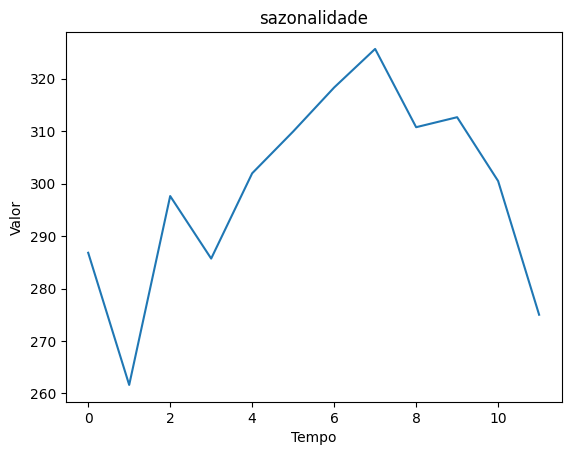

,sazonalidade
sazonalidade,
0,286.811100
1,261.630600
2,297.615075
3,285.702100
4,301.953300
5,309.914400
6,318.299950
7,325.649400
8,310.734600


In [137]:
def calculate_monthly_means(consume_of_cement, subject):
    df = pd.DataFrame({subject: consume_of_cement})
    df['sazonalidade'] = df.index % 12
    monthly_means = df.groupby('sazonalidade')[subject].mean()
    result_df = pd.DataFrame({'sazonalidade': monthly_means})

    return result_df

media_df = calculate_monthly_means(data[subject], subject)
plot_columns(media_df)
media_df

In [138]:
def fill_original_df_with_monthly_means(df_og, media_df):
    monthly_means = media_df['sazonalidade'].tolist()
    df_og['sazonalidade'] = [monthly_means[i % 12] for i in range(len(df_og))]
    return df_og

data = fill_original_df_with_monthly_means(data, media_df)
data = data[[col for col in data.columns if col != subject] + [subject]] #Seta consumo (target) para a coluna final
data

,Unnamed: 0,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Fluxo Mensal (Milhões de reais),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Global Radiation - Daylight (Kj/m²),Air Temperature - Dry Bulb (°C),Dew Point Temperature (°C),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,0.724032,-5331.049150,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.829159,1010.529618,1375.758786,25.748362,21.004370,77.778706,0.280924,199.081280,0.773489,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,8.356512,286.811100,254.362
1,2003-2,0.293538,0.690297,-5318.079644,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.243689,1011.819551,1351.395533,24.726628,19.944598,77.559351,0.437013,198.561780,0.773547,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,8.350332,261.630600,252.842
2,2003-3,0.295914,0.669681,-5436.417870,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.817902,1012.695061,1239.403439,23.660449,19.286759,78.925026,0.552353,198.773336,0.773606,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,8.344152,297.615075,229.385
3,2003-4,0.298264,0.660494,-5707.015274,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.641760,1013.728874,1209.362695,22.867266,18.421110,78.677330,0.640631,198.753800,0.773665,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,8.337971,285.702100,243.407
4,2003-5,0.300588,0.648337,-5599.317941,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.281770,1014.834769,1137.879019,21.790668,17.313914,78.556857,0.712532,198.721455,0.773724,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,8.331791,301.953300,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.464198,1014.333358,1037.298197,21.415455,18.059874,83.951199,0.670362,232.917513,NaN,NaN,NaN,NaN,NaN,NaN,325.649400,241.702
236,2022-9,0.558289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.720334,1013.180064,1026.463467,21.958073,18.797279,84.714086,0.659194,232.658000,NaN,NaN,NaN,NaN,NaN,NaN,310.734600,221.036
237,2022-10,0.556367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.780250,1012.520386,1043.708526,22.474325,19.343196,84.773545,0.665911,232.339116,NaN,NaN,NaN,NaN,NaN,NaN,312.638850,224.399
238,2022-11,0.554021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.922125,1012.172009,1045.153647,22.484809,19.414365,85.015544,0.669324,231.667333,NaN,NaN,NaN,NaN,NaN,NaN,300.478750,221.319


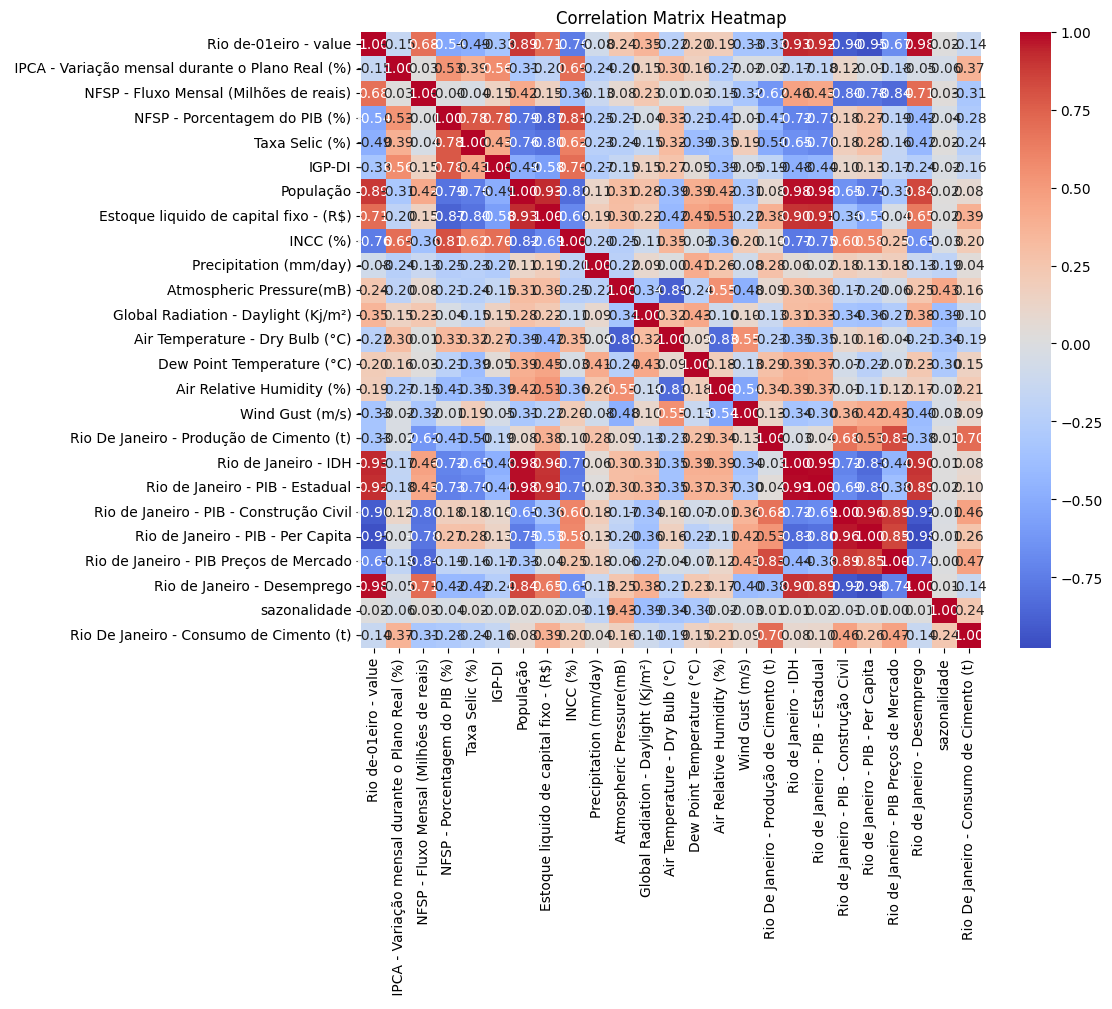

In [139]:
plot_data = data.iloc[:split_index + 1,1:]
plot_correlation_matrix(plot_data)

In [140]:
data =data.drop(['Global Radiation - Daylight (Kj/m²)',
                 ' NFSP - Fluxo Mensal (Milhões de reais)',
                 'Air Temperature - Dry Bulb (°C)', 
                 'Dew Point Temperature (°C)'], axis=1)
data

,Unnamed: 0,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade,Rio De Janeiro - Consumo de Cimento (t)
0,2003-1,0.291137,0.724032,11.520143,1.611498,1.036534,1.772069e+08,7.330309e+06,0.969649,2.829159,1010.529618,77.778706,0.280924,199.081280,0.773489,3.583430e+08,1.813534e+07,22.143720,3.472846e+08,8.356512,286.811100,254.362
1,2003-2,0.293538,0.690297,11.189862,1.450389,0.993449,1.773884e+08,7.335910e+06,0.950783,2.243689,1011.819551,77.559351,0.437013,198.561780,0.773547,3.587441e+08,1.814108e+07,22.149228,3.474056e+08,8.350332,261.630600,252.842
2,2003-3,0.295914,0.669681,10.820792,1.870184,0.973020,1.775699e+08,7.341511e+06,0.938332,1.817902,1012.695061,78.925026,0.552353,198.773336,0.773606,3.591452e+08,1.814681e+07,22.154735,3.475266e+08,8.344152,297.615075,229.385
3,2003-4,0.298264,0.660494,10.417840,1.355287,0.940489,1.777514e+08,7.347112e+06,0.926401,1.641760,1013.728874,78.677330,0.640631,198.753800,0.773665,3.595464e+08,1.815255e+07,22.160243,3.476476e+08,8.337971,285.702100,243.407
4,2003-5,0.300588,0.648337,9.959690,1.585538,0.917493,1.779329e+08,7.352713e+06,0.951683,1.281770,1014.834769,78.556857,0.712532,198.721455,0.773724,3.599475e+08,1.815828e+07,22.165750,3.477686e+08,8.331791,301.953300,256.535
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
235,2022-8,0.559828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.464198,1014.333358,83.951199,0.670362,232.917513,NaN,NaN,NaN,NaN,NaN,NaN,325.649400,241.702
236,2022-9,0.558289,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.720334,1013.180064,84.714086,0.659194,232.658000,NaN,NaN,NaN,NaN,NaN,NaN,310.734600,221.036
237,2022-10,0.556367,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.780250,1012.520386,84.773545,0.665911,232.339116,NaN,NaN,NaN,NaN,NaN,NaN,312.638850,224.399
238,2022-11,0.554021,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.922125,1012.172009,85.015544,0.669324,231.667333,NaN,NaN,NaN,NaN,NaN,NaN,300.478750,221.319


In [141]:
input_data = data.iloc[:split_index + 1,1:-1]
mean = np.mean(input_data, axis=0)
stddev =  np.std(input_data, axis=0)
input_data = ((input_data - mean) /stddev)
# scaler=MinMaxScaler()
# scaled_data = scaler.fit_transform(input_data)
# input_data = pd.DataFrame(scaled_data, columns=input_data.columns)
input_data

,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade
0,-1.533996,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,0.775020,-0.864677,-0.075433,-3.656745,-1.060779,-1.723389,-1.790542,0.136347,0.121226,-1.445055,-0.790925,-0.674444
1,-1.486609,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.211775,-0.279582,-0.106182,-2.634518,-1.079132,-1.706702,-1.768299,0.149077,0.152115,-1.365321,-0.794037,-2.082842
2,-1.439709,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.197847,0.117537,0.085260,-1.879151,-1.071658,-1.690015,-1.746055,0.161806,0.183005,-1.285587,-0.797148,-0.070154
3,-1.393318,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.367303,0.586460,0.050537,-1.301019,-1.072349,-1.673328,-1.723811,0.174535,0.213895,-1.205853,-0.800259,-0.736472
4,-1.347462,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.713627,1.088078,0.033649,-0.830139,-1.073491,-1.656642,-1.701567,0.187264,0.244784,-1.126118,-0.803370,0.172492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.438978,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.468897,0.787983,-0.525827,-0.696631,-0.476880,0.839598,1.110414,-1.635096,-1.325228,-1.036232,1.324172,1.497865
188,1.443990,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.230329,0.245695,-0.650783,-0.514316,-0.460898,0.793634,1.098172,-1.625552,-1.326867,-1.053116,1.322796,0.663649
189,1.457014,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.085560,-0.048798,-0.804007,-0.330804,-0.421271,0.747671,1.085930,-1.616009,-1.328507,-1.070000,1.321421,0.770157
190,1.470138,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.428083,-0.362841,-0.958655,-0.105169,-0.402090,0.701707,1.073688,-1.606465,-1.330147,-1.086883,1.320046,0.090017


In [142]:
# Shift para prever futuro e não presente
target_data = data[subject].shift(-12)
target_data

0      256.494
1      214.974
2      273.646
3      238.045
4      254.860
        ...   
235        NaN
236        NaN
237        NaN
238        NaN
239        NaN
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 240, dtype: float64

In [143]:
# input para treinamento
train_input = input_data.iloc[start_index:train_split]
train_input

,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade
0,-1.533996,2.723741,4.398348,2.132459,3.890153,-2.042341,-2.389042,3.122582,0.775020,-0.864677,-0.075433,-3.656745,-1.060779,-1.723389,-1.790542,0.136347,0.121226,-1.445055,-0.790925,-0.674444
1,-1.486609,2.350880,4.222509,1.592202,3.551840,-2.014760,-2.352139,2.970356,0.211775,-0.279582,-0.106182,-2.634518,-1.079132,-1.706702,-1.768299,0.149077,0.152115,-1.365321,-0.794037,-2.082842
2,-1.439709,2.123016,4.026019,2.999926,3.391423,-1.987179,-2.315236,2.869895,-0.197847,0.117537,0.085260,-1.879151,-1.071658,-1.690015,-1.746055,0.161806,0.183005,-1.285587,-0.797148,-0.070154
3,-1.393318,2.021477,3.811492,1.273293,3.135979,-1.959598,-2.278333,2.773628,-0.367303,0.586460,0.050537,-1.301019,-1.072349,-1.673328,-1.723811,0.174535,0.213895,-1.205853,-0.800259,-0.736472
4,-1.347462,1.887113,3.567576,2.045407,2.955412,-1.932017,-2.241431,2.977624,-0.713627,1.088078,0.033649,-0.830139,-1.073491,-1.656642,-1.701567,0.187264,0.244784,-1.126118,-0.803370,0.172492
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,1.395833,-0.214006,-0.607704,0.043807,-1.233012,1.031384,0.819304,-0.883659,0.340356,-0.273398,0.343806,-0.556221,-1.418673,1.438456,1.098176,-1.500012,-1.660268,-1.692180,1.473338,-2.082842
158,1.389960,-0.434717,-0.620523,0.210856,-1.299304,1.042716,0.808136,-0.950771,-0.167711,0.323190,0.487223,-0.897291,-1.470839,1.429097,1.105247,-1.521309,-1.646368,-1.657425,1.467585,-0.070154
159,1.384722,-0.524091,-0.631530,0.107070,-1.248662,1.054049,0.796969,-1.028465,-0.540479,0.796678,0.471151,-1.091838,-1.532363,1.419738,1.112318,-1.542605,-1.632469,-1.622671,1.461833,-0.736472
160,1.379646,-0.614500,-0.640320,0.392942,-1.068274,1.065381,0.785801,-1.103668,-0.598926,1.239359,0.499512,-1.087726,-1.608317,1.410379,1.119389,-1.563902,-1.618570,-1.587917,1.456081,0.172492


In [144]:
# Alvo para treinamento
train_target = target_data.iloc[start_index:train_split]
train_target

0      256.494
1      214.974
2      273.646
3      238.045
4      254.860
        ...   
157    175.917
158    208.629
159    181.933
160    187.947
161    181.556
Name: Rio De Janeiro - Consumo de Cimento (t), Length: 162, dtype: float64

In [145]:
def create_batches(t_input, t_target, window_size, start_from):
    
    X_batches = []
    y_batches = []

    train_input_values = t_input.values 

    for i in range(len(t_input) - window_size):
        
        X_window = train_input_values[i:i+window_size, :]
        y_target = t_target[start_from+i+window_size]

        X_batches.append(X_window)
        y_batches.append(y_target)

    return np.array(X_batches), np.array(y_batches)

In [146]:
reshaped_train, reshaped_target = create_batches(train_input, 
                                                 train_target, 
                                                 window_size, 
                                                 start_index)
reshaped_train.shape

(126, 36, 20)

In [147]:
# input para treinamento
test_input = input_data.iloc[train_split - window_size:split_index + 1]
test_input

,Rio de-01eiro - value,IPCA - Variação mensal durante o Plano Real (%),NFSP - Porcentagem do PIB (%),Taxa Selic (%),IGP-DI,População,Estoque liquido de capital fixo - (R$),INCC (%),Precipitation (mm/day),Atmospheric Pressure(mB),Air Relative Humidity (%),Wind Gust (m/s),Rio De Janeiro - Produção de Cimento (t),Rio de Janeiro - IDH,Rio de Janeiro - PIB - Estadual,Rio de Janeiro - PIB - Construção Civil,Rio de Janeiro - PIB - Per Capita,Rio de Janeiro - PIB Preços de Mercado,Rio de Janeiro - Desemprego,sazonalidade
126,0.575814,0.888984,-0.460555,-1.048761,-0.368821,0.651397,0.944085,0.045243,-0.562201,1.236507,0.500961,-0.444330,0.995998,0.797097,0.862422,-0.029106,-0.391329,0.186886,0.731632,1.086795
127,0.620950,0.954254,-0.440372,-0.649312,-0.328087,0.664707,0.947319,0.061828,-0.519854,0.889148,0.364433,-0.395212,0.926846,0.824296,0.875882,-0.083792,-0.444296,0.111052,0.766827,1.497865
128,0.671632,1.045217,-0.419247,-0.535369,-0.176031,0.678017,0.950553,0.046225,-0.399748,0.313103,0.407645,-0.376205,0.836461,0.851494,0.889342,-0.138478,-0.497262,0.035217,0.802021,0.663649
129,0.720432,1.176395,-0.397019,-1.288807,-0.113037,0.691327,0.953786,0.032522,-0.284296,-0.102129,0.309589,-0.331572,0.767757,0.878692,0.902802,-0.193163,-0.550229,-0.040617,0.837216,0.770157
130,0.766028,1.303259,-0.376532,-1.507550,-0.022703,0.704637,0.957020,0.042757,-0.137200,-0.519970,0.093186,-0.207908,0.681375,0.905890,0.916261,-0.247849,-0.603195,-0.116452,0.872410,0.090017
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
187,1.438978,-2.010387,-0.572934,-1.311366,0.589021,1.365911,0.389193,-1.749976,-0.468897,0.787983,-0.525827,-0.696631,-0.476880,0.839598,1.110414,-1.635096,-1.325228,-1.036232,1.324172,1.497865
188,1.443990,-1.870713,-0.588777,-1.417143,1.043728,1.376610,0.370392,-1.593005,-0.230329,0.245695,-0.650783,-0.514316,-0.460898,0.793634,1.098172,-1.625552,-1.326867,-1.053116,1.322796,0.663649
189,1.457014,-1.806230,-0.612606,-1.597784,1.387010,1.387308,0.351592,-1.351489,0.085560,-0.048798,-0.804007,-0.330804,-0.421271,0.747671,1.085930,-1.616009,-1.328507,-1.070000,1.321421,0.770157
190,1.470138,-1.727496,-0.640956,-1.400787,1.815728,1.398006,0.332791,-1.198492,0.428083,-0.362841,-0.958655,-0.105169,-0.402090,0.701707,1.073688,-1.606465,-1.330147,-1.086883,1.320046,0.090017


In [148]:
reshaped_test, reshaped_test_target = create_batches(test_input, 
                                                     target_data, 
                                                     window_size, 
                                                     train_split - window_size)
reshaped_test.shape 

(30, 36, 20)

In [149]:
def validation_splitter(arr, div_factor, add_factor=0):
    split_factor = len(arr) // div_factor
    positions_to_drop_index = []
    positions_to_drop = []
    for i in range(split_factor):
        pos = len(arr) - (i * div_factor + 1)
        positions_to_drop_index.append(pos)
        positions_to_drop.append(pos + add_factor)
    
    arr_droped = arr[positions_to_drop]
    arr_result = np.delete(arr, positions_to_drop_index, axis=0)
    
    return arr_result, arr_droped

In [150]:
# Rede Neural Recorrente com optmizador Estocástico
def lstm_model(train_input, train_target, want_verbose=1, seed=0):
    if seed != 0:
        random.seed(seed)
        np.random.seed(seed)
        tf.random.set_seed(seed)
    # Aṕos 500 epochs sem grandes melhoras no val_loss, interrompe.
    early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', 
                                                      patience=500, 
                                                      verbose=want_verbose, 
                                                      restore_best_weights=True,
                                                      start_from_epoch=500)
#     train, train_val = validation_splitter(train_input, 7)
#     target,target_val = validation_splitter(train_target, 7)
#     display(train.shape)
#     display(train_val.shape)
#     display(target.shape)
#     display(target_val.shape)
    # Método estocástico e learning rate=0.005
#     optimizer = tf.keras.optimizers.SGD(learning_rate=0.005)
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(128, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01),
                             input_shape=(reshaped_train.shape[1],
                                          reshaped_train.shape[2])),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.LSTM(64, activation='tanh', 
                             return_sequences=True,
                             kernel_regularizer=tf.keras.regularizers.l1(0.01)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Dense(32, activation='tanh'),
        tf.keras.layers.Dense(1)
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mean_squared_error')    
    history = model.fit(train_input, 
                        train_target, 
                        epochs=10000,
#                         validation_data=(train_val,
#                                          target_val),
                        validation_split=0.1,
                        callbacks=[early_stopping], 
                        verbose=want_verbose)
    return model, history

In [151]:
def get_a_good_seed(train_input, train_target, test_input, test_target):

    random_seeds = [random.randint(0, 2**32 - 1) for _ in range(5)]
    print(random_seeds)

    best_loss = float('inf')
    winner_seed = None
    i = 0
    for seed in random_seeds:
        print(f"\n\nStep: {i} ___________________________________________")
        i += 1

        model, history = lstm_model(train_input, train_target, want_verbose=0, seed=seed)
        current_loss = min(history.history['val_loss'][500:])
        print(f"val_loss: {current_loss}")

        if current_loss < best_loss:
            best_loss = current_loss
            winner_seed = seed
            print(f"winner_seed: {winner_seed}")
            if winner_seed == 0.0:
                return winner_seed

    return winner_seed

In [152]:
winner_seed = get_a_good_seed(reshaped_train, reshaped_target, reshaped_test, reshaped_test_target)
print(f"\n\nfinal_seed: {winner_seed}")

[2075418656, 2409266702, 2046636432, 3803124988, 2806733456]


Step: 0 ___________________________________________
val_loss: 971.1348876953125
winner_seed: 2075418656


Step: 1 ___________________________________________
val_loss: 970.9581298828125
winner_seed: 2409266702


Step: 2 ___________________________________________
val_loss: 971.0704345703125


Step: 3 ___________________________________________
val_loss: 971.359619140625


Step: 4 ___________________________________________
val_loss: 970.9627685546875


final_seed: 2409266702


In [153]:
trained_model, history = lstm_model(reshaped_train, 
                                    reshaped_target, 
                                    want_verbose=1, 
                                    seed=winner_seed)

Epoch 1/10000
4/4 [==============================] - 2s 138ms/step - loss: 133803.6406 - val_loss: 49809.9453
Epoch 2/10000
4/4 [==============================] - 0s 18ms/step - loss: 132963.3125 - val_loss: 49896.2422
Epoch 3/10000
4/4 [==============================] - 0s 16ms/step - loss: 131987.5000 - val_loss: 49717.1172
Epoch 4/10000
4/4 [==============================] - 0s 13ms/step - loss: 131073.6562 - val_loss: 49066.8672
Epoch 5/10000
4/4 [==============================] - 0s 12ms/step - loss: 130430.9219 - val_loss: 48363.5352
Epoch 6/10000
4/4 [==============================] - 0s 13ms/step - loss: 129965.5938 - val_loss: 48009.8672
Epoch 7/10000
4/4 [==============================] - 0s 13ms/step - loss: 129624.7344 - val_loss: 47811.8086
Epoch 8/10000
4/4 [==============================] - 0s 13ms/step - loss: 129365.8438 - val_loss: 47691.7031
Epoch 9/10000
4/4 [==============================] - 0s 14ms/step - loss: 129161.5859 - val_loss: 47642.9414
Epoch 10/10000
4/4

4/4 [==============================] - 0s 14ms/step - loss: 122246.7422 - val_loss: 45480.5859
Epoch 76/10000
4/4 [==============================] - 0s 14ms/step - loss: 122152.4453 - val_loss: 45441.8594
Epoch 77/10000
4/4 [==============================] - 0s 15ms/step - loss: 122058.6875 - val_loss: 45400.8203
Epoch 78/10000
4/4 [==============================] - 0s 17ms/step - loss: 121964.5781 - val_loss: 45361.0273
Epoch 79/10000
4/4 [==============================] - 0s 13ms/step - loss: 121871.2578 - val_loss: 45321.6719
Epoch 80/10000
4/4 [==============================] - 0s 13ms/step - loss: 121777.8281 - val_loss: 45282.8984
Epoch 81/10000
4/4 [==============================] - 0s 13ms/step - loss: 121685.2891 - val_loss: 45244.8672
Epoch 82/10000
4/4 [==============================] - 0s 13ms/step - loss: 121591.6641 - val_loss: 45202.7461
Epoch 83/10000
4/4 [==============================] - 0s 13ms/step - loss: 121498.4453 - val_loss: 45162.9219
Epoch 84/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 115537.6484 - val_loss: 42326.3203
Epoch 150/10000
4/4 [==============================] - 0s 15ms/step - loss: 115449.9531 - val_loss: 42295.2969
Epoch 151/10000
4/4 [==============================] - 0s 14ms/step - loss: 115361.2266 - val_loss: 42262.4219
Epoch 152/10000
4/4 [==============================] - 0s 13ms/step - loss: 115273.2656 - val_loss: 42230.4297
Epoch 153/10000
4/4 [==============================] - 0s 16ms/step - loss: 115185.5078 - val_loss: 42198.2578
Epoch 154/10000
4/4 [==============================] - 0s 16ms/step - loss: 115097.4766 - val_loss: 42167.7734
Epoch 155/10000
4/4 [==============================] - 0s 14ms/step - loss: 115009.5859 - val_loss: 42136.5039
Epoch 156/10000
4/4 [==============================] - 0s 12ms/step - loss: 114921.3906 - val_loss: 42106.0039
Epoch 157/10000
4/4 [==============================] - 0s 13ms/step - loss: 114833.8438 - val_loss: 42075.8789
Epoch 158/10000
4

Epoch 223/10000
4/4 [==============================] - 0s 16ms/step - loss: 109173.2734 - val_loss: 40242.9727
Epoch 224/10000
4/4 [==============================] - 0s 14ms/step - loss: 109088.3828 - val_loss: 40210.3320
Epoch 225/10000
4/4 [==============================] - 0s 13ms/step - loss: 109004.0391 - val_loss: 40182.8125
Epoch 226/10000
4/4 [==============================] - 0s 13ms/step - loss: 108920.6172 - val_loss: 40156.4336
Epoch 227/10000
4/4 [==============================] - 0s 13ms/step - loss: 108835.4609 - val_loss: 40130.7266
Epoch 228/10000
4/4 [==============================] - 0s 15ms/step - loss: 108752.4062 - val_loss: 40108.1094
Epoch 229/10000
4/4 [==============================] - 0s 15ms/step - loss: 108668.5625 - val_loss: 40088.4688
Epoch 230/10000
4/4 [==============================] - 0s 14ms/step - loss: 108584.3984 - val_loss: 40073.9180
Epoch 231/10000
4/4 [==============================] - 0s 12ms/step - loss: 108500.2422 - val_loss: 40059.7812
E

Epoch 297/10000
4/4 [==============================] - 0s 12ms/step - loss: 103082.5078 - val_loss: 38621.3203
Epoch 298/10000
4/4 [==============================] - 0s 16ms/step - loss: 103001.6016 - val_loss: 38601.8984
Epoch 299/10000
4/4 [==============================] - 0s 13ms/step - loss: 102921.5078 - val_loss: 38581.0547
Epoch 300/10000
4/4 [==============================] - 0s 13ms/step - loss: 102841.1172 - val_loss: 38562.0273
Epoch 301/10000
4/4 [==============================] - 0s 13ms/step - loss: 102759.5625 - val_loss: 38544.5703
Epoch 302/10000
4/4 [==============================] - 0s 13ms/step - loss: 102680.1328 - val_loss: 38524.2500
Epoch 303/10000
4/4 [==============================] - 0s 14ms/step - loss: 102599.6484 - val_loss: 38506.5156
Epoch 304/10000
4/4 [==============================] - 0s 13ms/step - loss: 102519.1094 - val_loss: 38485.7305
Epoch 305/10000
4/4 [==============================] - 0s 13ms/step - loss: 102438.5312 - val_loss: 38467.5664
E

4/4 [==============================] - 0s 13ms/step - loss: 97240.0859 - val_loss: 37258.0469
Epoch 372/10000
4/4 [==============================] - 0s 13ms/step - loss: 97163.1875 - val_loss: 37250.7812
Epoch 373/10000
4/4 [==============================] - 0s 12ms/step - loss: 97086.0469 - val_loss: 37242.2617
Epoch 374/10000
4/4 [==============================] - 0s 13ms/step - loss: 97008.7969 - val_loss: 37235.2070
Epoch 375/10000
4/4 [==============================] - 0s 13ms/step - loss: 96931.3750 - val_loss: 37227.2773
Epoch 376/10000
4/4 [==============================] - 0s 14ms/step - loss: 96854.0859 - val_loss: 37219.3906
Epoch 377/10000
4/4 [==============================] - 0s 13ms/step - loss: 96777.7734 - val_loss: 37210.3203
Epoch 378/10000
4/4 [==============================] - 0s 12ms/step - loss: 96700.3516 - val_loss: 37200.6484
Epoch 379/10000
4/4 [==============================] - 0s 12ms/step - loss: 96623.6016 - val_loss: 37187.6836
Epoch 380/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 91635.3750 - val_loss: 36151.6445
Epoch 446/10000
4/4 [==============================] - 0s 14ms/step - loss: 91561.5938 - val_loss: 36147.0938
Epoch 447/10000
4/4 [==============================] - 0s 17ms/step - loss: 91486.6250 - val_loss: 36142.1602
Epoch 448/10000
4/4 [==============================] - 0s 15ms/step - loss: 91412.8047 - val_loss: 36133.3633
Epoch 449/10000
4/4 [==============================] - 0s 11ms/step - loss: 91339.1406 - val_loss: 36126.2969
Epoch 450/10000
4/4 [==============================] - 0s 13ms/step - loss: 91264.1953 - val_loss: 36114.5938
Epoch 451/10000
4/4 [==============================] - 0s 12ms/step - loss: 91190.1250 - val_loss: 36103.9023
Epoch 452/10000
4/4 [==============================] - 0s 13ms/step - loss: 91116.5078 - val_loss: 36090.7656
Epoch 453/10000
4/4 [==============================] - 0s 14ms/step - loss: 91042.4062 - val_loss: 36072.7422
Epoch 454/10000
4/4 [=====

4/4 [==============================] - 0s 12ms/step - loss: 86249.1797 - val_loss: 35296.5742
Epoch 520/10000
4/4 [==============================] - 0s 14ms/step - loss: 86177.1406 - val_loss: 35277.6484
Epoch 521/10000
4/4 [==============================] - 0s 13ms/step - loss: 86106.1094 - val_loss: 35262.1641
Epoch 522/10000
4/4 [==============================] - 0s 15ms/step - loss: 86034.5625 - val_loss: 35248.3242
Epoch 523/10000
4/4 [==============================] - 0s 15ms/step - loss: 85963.4609 - val_loss: 35238.2969
Epoch 524/10000
4/4 [==============================] - 0s 13ms/step - loss: 85892.3906 - val_loss: 35227.7891
Epoch 525/10000
4/4 [==============================] - 0s 12ms/step - loss: 85821.0469 - val_loss: 35213.9805
Epoch 526/10000
4/4 [==============================] - 0s 13ms/step - loss: 85749.2734 - val_loss: 35200.4531
Epoch 527/10000
4/4 [==============================] - 0s 13ms/step - loss: 85678.9922 - val_loss: 35189.5352
Epoch 528/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 81074.5469 - val_loss: 36616.0234
Epoch 594/10000
4/4 [==============================] - 0s 15ms/step - loss: 81006.0625 - val_loss: 36648.7539
Epoch 595/10000
4/4 [==============================] - 0s 15ms/step - loss: 80937.4688 - val_loss: 36599.3164
Epoch 596/10000
4/4 [==============================] - 0s 15ms/step - loss: 80868.7188 - val_loss: 36572.5508
Epoch 597/10000
4/4 [==============================] - 0s 13ms/step - loss: 80800.9766 - val_loss: 36598.6055
Epoch 598/10000
4/4 [==============================] - 0s 14ms/step - loss: 80731.9609 - val_loss: 36603.3086
Epoch 599/10000
4/4 [==============================] - 0s 16ms/step - loss: 80664.3750 - val_loss: 36556.3438
Epoch 600/10000
4/4 [==============================] - 0s 16ms/step - loss: 80596.1328 - val_loss: 36591.3516
Epoch 601/10000
4/4 [==============================] - 0s 12ms/step - loss: 80527.5078 - val_loss: 36631.4453
Epoch 602/10000
4/4 [=====

4/4 [==============================] - 0s 12ms/step - loss: 76101.4453 - val_loss: 33680.8516
Epoch 668/10000
4/4 [==============================] - 0s 12ms/step - loss: 76035.7422 - val_loss: 33671.3125
Epoch 669/10000
4/4 [==============================] - 0s 12ms/step - loss: 75969.9141 - val_loss: 33662.4961
Epoch 670/10000
4/4 [==============================] - 0s 11ms/step - loss: 75903.9922 - val_loss: 33640.6055
Epoch 671/10000
4/4 [==============================] - 0s 11ms/step - loss: 75837.8906 - val_loss: 33622.5977
Epoch 672/10000
4/4 [==============================] - 0s 11ms/step - loss: 75772.4766 - val_loss: 33606.4492
Epoch 673/10000
4/4 [==============================] - 0s 11ms/step - loss: 75707.0078 - val_loss: 33559.6016
Epoch 674/10000
4/4 [==============================] - 0s 11ms/step - loss: 75640.3594 - val_loss: 33529.3203
Epoch 675/10000
4/4 [==============================] - 0s 11ms/step - loss: 75574.9531 - val_loss: 33511.0039
Epoch 676/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 71323.5156 - val_loss: 32880.1758
Epoch 742/10000
4/4 [==============================] - 0s 14ms/step - loss: 71259.9844 - val_loss: 32868.3594
Epoch 743/10000
4/4 [==============================] - 0s 14ms/step - loss: 71196.8125 - val_loss: 32859.5938
Epoch 744/10000
4/4 [==============================] - 0s 17ms/step - loss: 71133.4531 - val_loss: 32850.1211
Epoch 745/10000
4/4 [==============================] - 0s 15ms/step - loss: 71069.8516 - val_loss: 32836.0625
Epoch 746/10000
4/4 [==============================] - 0s 14ms/step - loss: 71006.3750 - val_loss: 32826.9180
Epoch 747/10000
4/4 [==============================] - 0s 15ms/step - loss: 70943.4219 - val_loss: 32819.2539
Epoch 748/10000
4/4 [==============================] - 0s 15ms/step - loss: 70880.4375 - val_loss: 32793.3828
Epoch 749/10000
4/4 [==============================] - 0s 17ms/step - loss: 70817.0078 - val_loss: 32752.2109
Epoch 750/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 66740.7109 - val_loss: 31758.5000
Epoch 816/10000
4/4 [==============================] - 0s 13ms/step - loss: 66680.5391 - val_loss: 31749.8340
Epoch 817/10000
4/4 [==============================] - 0s 15ms/step - loss: 66619.0469 - val_loss: 31737.5312
Epoch 818/10000
4/4 [==============================] - 0s 15ms/step - loss: 66558.4375 - val_loss: 31727.4082
Epoch 819/10000
4/4 [==============================] - 0s 14ms/step - loss: 66497.6953 - val_loss: 31713.4473
Epoch 820/10000
4/4 [==============================] - 0s 13ms/step - loss: 66437.1172 - val_loss: 31700.1113
Epoch 821/10000
4/4 [==============================] - 0s 13ms/step - loss: 66376.9531 - val_loss: 31685.2012
Epoch 822/10000
4/4 [==============================] - 0s 14ms/step - loss: 66316.3047 - val_loss: 31669.2168
Epoch 823/10000
4/4 [==============================] - 0s 15ms/step - loss: 66255.5781 - val_loss: 31651.7539
Epoch 824/10000
4/4 [=====

4/4 [==============================] - 0s 15ms/step - loss: 62338.3750 - val_loss: 30357.4258
Epoch 890/10000
4/4 [==============================] - 0s 19ms/step - loss: 62279.8203 - val_loss: 30311.8711
Epoch 891/10000
4/4 [==============================] - 0s 14ms/step - loss: 62222.2695 - val_loss: 30281.4102
Epoch 892/10000
4/4 [==============================] - 0s 14ms/step - loss: 62163.6797 - val_loss: 30244.1855
Epoch 893/10000
4/4 [==============================] - 0s 14ms/step - loss: 62105.5898 - val_loss: 30222.2227
Epoch 894/10000
4/4 [==============================] - 0s 16ms/step - loss: 62047.6055 - val_loss: 30202.1289
Epoch 895/10000
4/4 [==============================] - 0s 15ms/step - loss: 61989.7266 - val_loss: 30178.8887
Epoch 896/10000
4/4 [==============================] - 0s 14ms/step - loss: 61931.8242 - val_loss: 30145.6523
Epoch 897/10000
4/4 [==============================] - 0s 14ms/step - loss: 61873.7969 - val_loss: 30120.1445
Epoch 898/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 58118.0938 - val_loss: 23988.6641
Epoch 964/10000
4/4 [==============================] - 0s 15ms/step - loss: 58061.9414 - val_loss: 23970.4277
Epoch 965/10000
4/4 [==============================] - 0s 15ms/step - loss: 58006.2109 - val_loss: 23942.5977
Epoch 966/10000
4/4 [==============================] - 0s 16ms/step - loss: 57950.2305 - val_loss: 23922.1738
Epoch 967/10000
4/4 [==============================] - 0s 14ms/step - loss: 57894.3281 - val_loss: 23899.2090
Epoch 968/10000
4/4 [==============================] - 0s 15ms/step - loss: 57838.8477 - val_loss: 23872.7695
Epoch 969/10000
4/4 [==============================] - 0s 13ms/step - loss: 57782.9922 - val_loss: 23854.4609
Epoch 970/10000
4/4 [==============================] - 0s 14ms/step - loss: 57727.2734 - val_loss: 23832.7383
Epoch 971/10000
4/4 [==============================] - 0s 15ms/step - loss: 57671.8359 - val_loss: 23809.9238
Epoch 972/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 54073.9570 - val_loss: 22252.5742
Epoch 1038/10000
4/4 [==============================] - 0s 16ms/step - loss: 54020.1094 - val_loss: 22208.9375
Epoch 1039/10000
4/4 [==============================] - 0s 18ms/step - loss: 53966.9531 - val_loss: 22176.1211
Epoch 1040/10000
4/4 [==============================] - 0s 13ms/step - loss: 53913.0898 - val_loss: 22144.0234
Epoch 1041/10000
4/4 [==============================] - 0s 14ms/step - loss: 53860.1758 - val_loss: 22093.8164
Epoch 1042/10000
4/4 [==============================] - 0s 16ms/step - loss: 53806.2930 - val_loss: 22037.7148
Epoch 1043/10000
4/4 [==============================] - 0s 16ms/step - loss: 53752.5742 - val_loss: 21993.5020
Epoch 1044/10000
4/4 [==============================] - 0s 14ms/step - loss: 53699.5430 - val_loss: 21952.4980
Epoch 1045/10000
4/4 [==============================] - 0s 14ms/step - loss: 53646.0898 - val_loss: 21900.1445
Epoch 1046/10000
4

Epoch 1111/10000
4/4 [==============================] - 0s 14ms/step - loss: 50198.7773 - val_loss: 14441.1074
Epoch 1112/10000
4/4 [==============================] - 0s 14ms/step - loss: 50147.8281 - val_loss: 14416.8223
Epoch 1113/10000
4/4 [==============================] - 0s 14ms/step - loss: 50096.6289 - val_loss: 14387.0645
Epoch 1114/10000
4/4 [==============================] - 0s 15ms/step - loss: 50046.0234 - val_loss: 14362.9414
Epoch 1115/10000
4/4 [==============================] - 0s 16ms/step - loss: 49994.7422 - val_loss: 14336.0430
Epoch 1116/10000
4/4 [==============================] - 0s 14ms/step - loss: 49943.7070 - val_loss: 14309.7607
Epoch 1117/10000
4/4 [==============================] - 0s 15ms/step - loss: 49892.4688 - val_loss: 14283.3730
Epoch 1118/10000
4/4 [==============================] - 0s 14ms/step - loss: 49841.3945 - val_loss: 14260.4199
Epoch 1119/10000
4/4 [==============================] - 0s 14ms/step - loss: 49790.7383 - val_loss: 14236.1895
E

Epoch 1185/10000
4/4 [==============================] - 0s 19ms/step - loss: 46500.9883 - val_loss: 5619.1777
Epoch 1186/10000
4/4 [==============================] - 0s 13ms/step - loss: 46451.8750 - val_loss: 5603.4165
Epoch 1187/10000
4/4 [==============================] - 0s 15ms/step - loss: 46403.7188 - val_loss: 5587.6084
Epoch 1188/10000
4/4 [==============================] - 0s 14ms/step - loss: 46354.4023 - val_loss: 5571.8838
Epoch 1189/10000
4/4 [==============================] - 0s 16ms/step - loss: 46305.8711 - val_loss: 5556.1880
Epoch 1190/10000
4/4 [==============================] - 0s 15ms/step - loss: 46257.4688 - val_loss: 5540.4912
Epoch 1191/10000
4/4 [==============================] - 0s 13ms/step - loss: 46208.2461 - val_loss: 5524.8877
Epoch 1192/10000
4/4 [==============================] - 0s 14ms/step - loss: 46159.6797 - val_loss: 5509.2705
Epoch 1193/10000
4/4 [==============================] - 0s 16ms/step - loss: 46111.3438 - val_loss: 5493.6396
Epoch 1194

4/4 [==============================] - 0s 16ms/step - loss: 42974.1797 - val_loss: 4527.7837
Epoch 1260/10000
4/4 [==============================] - 0s 13ms/step - loss: 42927.5859 - val_loss: 4514.0708
Epoch 1261/10000
4/4 [==============================] - 0s 14ms/step - loss: 42881.1367 - val_loss: 4500.3809
Epoch 1262/10000
4/4 [==============================] - 0s 17ms/step - loss: 42834.8125 - val_loss: 4486.6714
Epoch 1263/10000
4/4 [==============================] - 0s 16ms/step - loss: 42788.4141 - val_loss: 4472.9995
Epoch 1264/10000
4/4 [==============================] - 0s 13ms/step - loss: 42741.6211 - val_loss: 4459.4072
Epoch 1265/10000
4/4 [==============================] - 0s 13ms/step - loss: 42695.3398 - val_loss: 4445.8213
Epoch 1266/10000
4/4 [==============================] - 0s 14ms/step - loss: 42648.8906 - val_loss: 4432.2393
Epoch 1267/10000
4/4 [==============================] - 0s 14ms/step - loss: 42602.1719 - val_loss: 4418.6938
Epoch 1268/10000
4/4 [=====

4/4 [==============================] - 0s 19ms/step - loss: 39609.7812 - val_loss: 3586.8333
Epoch 1334/10000
4/4 [==============================] - 0s 13ms/step - loss: 39565.5391 - val_loss: 3575.1323
Epoch 1335/10000
4/4 [==============================] - 0s 12ms/step - loss: 39520.7969 - val_loss: 3563.4988
Epoch 1336/10000
4/4 [==============================] - 0s 13ms/step - loss: 39476.5547 - val_loss: 3551.8589
Epoch 1337/10000
4/4 [==============================] - 0s 14ms/step - loss: 39432.2656 - val_loss: 3540.2439
Epoch 1338/10000
4/4 [==============================] - 0s 14ms/step - loss: 39388.2812 - val_loss: 3528.6267
Epoch 1339/10000
4/4 [==============================] - 0s 15ms/step - loss: 39343.8789 - val_loss: 3517.0337
Epoch 1340/10000
4/4 [==============================] - 0s 14ms/step - loss: 39299.4766 - val_loss: 3505.4609
Epoch 1341/10000
4/4 [==============================] - 0s 14ms/step - loss: 39255.3750 - val_loss: 3493.9036
Epoch 1342/10000
4/4 [=====

4/4 [==============================] - 0s 15ms/step - loss: 36406.4883 - val_loss: 2794.2224
Epoch 1408/10000
4/4 [==============================] - 0s 14ms/step - loss: 36364.1094 - val_loss: 2784.5200
Epoch 1409/10000
4/4 [==============================] - 0s 13ms/step - loss: 36322.0547 - val_loss: 2774.8464
Epoch 1410/10000
4/4 [==============================] - 0s 14ms/step - loss: 36280.1797 - val_loss: 2765.1802
Epoch 1411/10000
4/4 [==============================] - 0s 17ms/step - loss: 36237.6680 - val_loss: 2755.5884
Epoch 1412/10000
4/4 [==============================] - 0s 13ms/step - loss: 36195.6914 - val_loss: 2746.0144
Epoch 1413/10000
4/4 [==============================] - 0s 13ms/step - loss: 36154.0273 - val_loss: 2736.4448
Epoch 1414/10000
4/4 [==============================] - 0s 15ms/step - loss: 36111.8633 - val_loss: 2726.9192
Epoch 1415/10000
4/4 [==============================] - 0s 16ms/step - loss: 36069.4297 - val_loss: 2717.4302
Epoch 1416/10000
4/4 [=====

4/4 [==============================] - 0s 15ms/step - loss: 33368.8438 - val_loss: 2148.8657
Epoch 1482/10000
4/4 [==============================] - 0s 17ms/step - loss: 33328.8125 - val_loss: 2141.1133
Epoch 1483/10000
4/4 [==============================] - 0s 12ms/step - loss: 33289.0742 - val_loss: 2133.3665
Epoch 1484/10000
4/4 [==============================] - 0s 14ms/step - loss: 33249.0312 - val_loss: 2125.6592
Epoch 1485/10000
4/4 [==============================] - 0s 16ms/step - loss: 33209.0430 - val_loss: 2117.9839
Epoch 1486/10000
4/4 [==============================] - 0s 18ms/step - loss: 33169.4258 - val_loss: 2110.3328
Epoch 1487/10000
4/4 [==============================] - 0s 14ms/step - loss: 33129.1875 - val_loss: 2102.7576
Epoch 1488/10000
4/4 [==============================] - 0s 13ms/step - loss: 33089.4336 - val_loss: 2095.2087
Epoch 1489/10000
4/4 [==============================] - 0s 13ms/step - loss: 33049.8672 - val_loss: 2087.6523
Epoch 1490/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 30489.1719 - val_loss: 1646.5156
Epoch 1556/10000
4/4 [==============================] - 0s 14ms/step - loss: 30450.7520 - val_loss: 1640.7009
Epoch 1557/10000
4/4 [==============================] - 0s 16ms/step - loss: 30412.9844 - val_loss: 1634.8932
Epoch 1558/10000
4/4 [==============================] - 0s 17ms/step - loss: 30375.3867 - val_loss: 1629.0846
Epoch 1559/10000
4/4 [==============================] - 0s 14ms/step - loss: 30337.4043 - val_loss: 1623.3254
Epoch 1560/10000
4/4 [==============================] - 0s 14ms/step - loss: 30299.9727 - val_loss: 1617.5916
Epoch 1561/10000
4/4 [==============================] - 0s 16ms/step - loss: 30261.6543 - val_loss: 1611.9370
Epoch 1562/10000
4/4 [==============================] - 0s 14ms/step - loss: 30224.5098 - val_loss: 1606.2747
Epoch 1563/10000
4/4 [==============================] - 0s 16ms/step - loss: 30186.9512 - val_loss: 1600.6367
Epoch 1564/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 27768.9688 - val_loss: 1285.3127
Epoch 1630/10000
4/4 [==============================] - 0s 14ms/step - loss: 27733.4688 - val_loss: 1281.3837
Epoch 1631/10000
4/4 [==============================] - 0s 14ms/step - loss: 27698.1680 - val_loss: 1277.4659
Epoch 1632/10000
4/4 [==============================] - 0s 17ms/step - loss: 27662.2734 - val_loss: 1273.5917
Epoch 1633/10000
4/4 [==============================] - 0s 15ms/step - loss: 27626.6289 - val_loss: 1269.7489
Epoch 1634/10000
4/4 [==============================] - 0s 14ms/step - loss: 27590.9883 - val_loss: 1265.9355
Epoch 1635/10000
4/4 [==============================] - 0s 16ms/step - loss: 27556.0312 - val_loss: 1262.1146
Epoch 1636/10000
4/4 [==============================] - 0s 17ms/step - loss: 27520.3047 - val_loss: 1258.3318
Epoch 1637/10000
4/4 [==============================] - 0s 13ms/step - loss: 27484.6113 - val_loss: 1254.5833
Epoch 1638/10000
4/4 [=====

4/4 [==============================] - 0s 17ms/step - loss: 25202.7949 - val_loss: 1061.6442
Epoch 1704/10000
4/4 [==============================] - 0s 15ms/step - loss: 25169.1602 - val_loss: 1059.5535
Epoch 1705/10000
4/4 [==============================] - 0s 12ms/step - loss: 25135.8145 - val_loss: 1057.4911
Epoch 1706/10000
4/4 [==============================] - 0s 15ms/step - loss: 25102.2734 - val_loss: 1055.4634
Epoch 1707/10000
4/4 [==============================] - 0s 14ms/step - loss: 25068.8633 - val_loss: 1053.4622
Epoch 1708/10000
4/4 [==============================] - 0s 13ms/step - loss: 25035.6211 - val_loss: 1051.4821
Epoch 1709/10000
4/4 [==============================] - 0s 14ms/step - loss: 25002.5098 - val_loss: 1049.5176
Epoch 1710/10000
4/4 [==============================] - 0s 14ms/step - loss: 24968.6230 - val_loss: 1047.5854
Epoch 1711/10000
4/4 [==============================] - 0s 17ms/step - loss: 24935.9473 - val_loss: 1045.6611
Epoch 1712/10000
4/4 [=====

Epoch 1778/10000
4/4 [==============================] - 0s 16ms/step - loss: 22764.6816 - val_loss: 972.6332
Epoch 1779/10000
4/4 [==============================] - 0s 13ms/step - loss: 22733.2500 - val_loss: 972.3624
Epoch 1780/10000
4/4 [==============================] - 0s 14ms/step - loss: 22701.5312 - val_loss: 972.1157
Epoch 1781/10000
4/4 [==============================] - 0s 14ms/step - loss: 22670.4180 - val_loss: 971.8916
Epoch 1782/10000
4/4 [==============================] - 0s 16ms/step - loss: 22639.0391 - val_loss: 971.6912
Epoch 1783/10000
4/4 [==============================] - 0s 13ms/step - loss: 22607.3906 - val_loss: 971.5162
Epoch 1784/10000
4/4 [==============================] - 0s 12ms/step - loss: 22576.1719 - val_loss: 971.3648
Epoch 1785/10000
4/4 [==============================] - 0s 13ms/step - loss: 22544.9160 - val_loss: 971.2372
Epoch 1786/10000
4/4 [==============================] - 0s 14ms/step - loss: 22513.8945 - val_loss: 971.1329
Epoch 1787/10000
4/

4/4 [==============================] - 0s 12ms/step - loss: 20479.2031 - val_loss: 1018.1514
Epoch 1854/10000
4/4 [==============================] - 0s 13ms/step - loss: 20450.4160 - val_loss: 1019.6445
Epoch 1855/10000
4/4 [==============================] - 0s 13ms/step - loss: 20420.7227 - val_loss: 1021.1528
Epoch 1856/10000
4/4 [==============================] - 0s 13ms/step - loss: 20391.9629 - val_loss: 1022.6937
Epoch 1857/10000
4/4 [==============================] - 0s 13ms/step - loss: 20362.7402 - val_loss: 1024.2515
Epoch 1858/10000
4/4 [==============================] - 0s 12ms/step - loss: 20333.3828 - val_loss: 1025.8319
Epoch 1859/10000
4/4 [==============================] - 0s 13ms/step - loss: 20303.8027 - val_loss: 1027.4315
Epoch 1860/10000
4/4 [==============================] - 0s 13ms/step - loss: 20275.0703 - val_loss: 1029.0706
Epoch 1861/10000
4/4 [==============================] - 0s 13ms/step - loss: 20246.3594 - val_loss: 1030.7465
Epoch 1862/10000
4/4 [=====

4/4 [==============================] - 0s 16ms/step - loss: 18377.2188 - val_loss: 1191.1898
Epoch 1928/10000
4/4 [==============================] - 0s 14ms/step - loss: 18349.8203 - val_loss: 1194.3551
Epoch 1929/10000
4/4 [==============================] - 0s 13ms/step - loss: 18322.2930 - val_loss: 1197.5352
Epoch 1930/10000
4/4 [==============================] - 0s 13ms/step - loss: 18295.4746 - val_loss: 1200.7772
Epoch 1931/10000
4/4 [==============================] - 0s 13ms/step - loss: 18268.4805 - val_loss: 1204.0522
Epoch 1932/10000
4/4 [==============================] - 0s 13ms/step - loss: 18240.7578 - val_loss: 1207.3192
Epoch 1933/10000
4/4 [==============================] - 0s 14ms/step - loss: 18213.6953 - val_loss: 1210.6028
Epoch 1934/10000
4/4 [==============================] - 0s 15ms/step - loss: 18186.5273 - val_loss: 1213.9126
Epoch 1935/10000
4/4 [==============================] - 0s 13ms/step - loss: 18159.3027 - val_loss: 1217.2446
Epoch 1936/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 16424.5508 - val_loss: 1486.9794
Epoch 2002/10000
4/4 [==============================] - 0s 16ms/step - loss: 16399.2559 - val_loss: 1491.7644
Epoch 2003/10000
4/4 [==============================] - 0s 14ms/step - loss: 16373.9834 - val_loss: 1496.5750
Epoch 2004/10000
4/4 [==============================] - 0s 13ms/step - loss: 16348.0869 - val_loss: 1501.3777
Epoch 2005/10000
4/4 [==============================] - 0s 13ms/step - loss: 16323.5303 - val_loss: 1506.2919
Epoch 2006/10000
4/4 [==============================] - 0s 13ms/step - loss: 16297.5400 - val_loss: 1511.1646
Epoch 2007/10000
4/4 [==============================] - 0s 13ms/step - loss: 16272.7402 - val_loss: 1516.1150
Epoch 2008/10000
4/4 [==============================] - 0s 14ms/step - loss: 16247.4668 - val_loss: 1521.0813
Epoch 2009/10000
4/4 [==============================] - 0s 13ms/step - loss: 16222.4141 - val_loss: 1526.0634
Epoch 2010/10000
4/4 [=====

4/4 [==============================] - 0s 14ms/step - loss: 14620.1904 - val_loss: 1900.1610
Epoch 2076/10000
4/4 [==============================] - 0s 14ms/step - loss: 14596.7451 - val_loss: 1906.5072
Epoch 2077/10000
4/4 [==============================] - 0s 13ms/step - loss: 14573.6035 - val_loss: 1912.8854
Epoch 2078/10000
4/4 [==============================] - 0s 16ms/step - loss: 14550.0439 - val_loss: 1919.2600
Epoch 2079/10000
4/4 [==============================] - 0s 17ms/step - loss: 14526.7158 - val_loss: 1925.6962
Epoch 2080/10000
4/4 [==============================] - 0s 13ms/step - loss: 14503.3867 - val_loss: 1932.1835
Epoch 2081/10000
4/4 [==============================] - 0s 12ms/step - loss: 14479.9512 - val_loss: 1938.6913
Epoch 2082/10000
4/4 [==============================] - 0s 13ms/step - loss: 14456.8340 - val_loss: 1945.2408
Epoch 2083/10000
4/4 [==============================] - 0s 14ms/step - loss: 14433.1758 - val_loss: 1951.7626
Epoch 2084/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 12955.9746 - val_loss: 2426.6777
Epoch 2150/10000
4/4 [==============================] - 0s 12ms/step - loss: 12934.9443 - val_loss: 2434.4709
Epoch 2151/10000
4/4 [==============================] - 0s 12ms/step - loss: 12913.6934 - val_loss: 2442.3574
Epoch 2152/10000
4/4 [==============================] - 0s 14ms/step - loss: 12891.9531 - val_loss: 2450.2554
Epoch 2153/10000
4/4 [==============================] - 0s 13ms/step - loss: 12870.5469 - val_loss: 2458.2034
Epoch 2154/10000
4/4 [==============================] - 0s 15ms/step - loss: 12849.0420 - val_loss: 2466.1826
Epoch 2155/10000
4/4 [==============================] - 0s 14ms/step - loss: 12827.8320 - val_loss: 2474.2078
Epoch 2156/10000
4/4 [==============================] - 0s 14ms/step - loss: 12806.2559 - val_loss: 2482.2219
Epoch 2157/10000
4/4 [==============================] - 0s 13ms/step - loss: 12784.9531 - val_loss: 2490.2939
Epoch 2158/10000
4/4 [=====

4/4 [==============================] - 0s 13ms/step - loss: 11429.9990 - val_loss: 3061.9253
Epoch 2224/10000
4/4 [==============================] - 0s 16ms/step - loss: 11410.1055 - val_loss: 3071.2319
Epoch 2225/10000
4/4 [==============================] - 0s 15ms/step - loss: 11390.1826 - val_loss: 3080.5464
Epoch 2226/10000
4/4 [==============================] - 0s 13ms/step - loss: 11370.7822 - val_loss: 3089.8806
Epoch 2227/10000
4/4 [==============================] - 0s 13ms/step - loss: 11350.8535 - val_loss: 3099.1714
Epoch 2228/10000
4/4 [==============================] - 0s 13ms/step - loss: 11331.4951 - val_loss: 3108.5779
Epoch 2229/10000
4/4 [==============================] - 0s 13ms/step - loss: 11311.8359 - val_loss: 3117.9880
Epoch 2230/10000
4/4 [==============================] - 0s 13ms/step - loss: 11292.1416 - val_loss: 3127.3989
Epoch 2231/10000
4/4 [==============================] - 0s 15ms/step - loss: 11272.8857 - val_loss: 3136.8879
Epoch 2232/10000
4/4 [=====

In [154]:
def mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    results_data = []

    for i in range(len(test_target)):
        prediction = model.predict(test_input[i:i+1])
        target = test_target[start_target + i]
        error = np.abs(prediction - target)
        errors.append(error)
        error_percent.append(error/target)
        results_data.append([f"Month-{i + 1}", 
                             prediction[0][0][0], 
                             target, 
                             error[0][0][0]])

    df_results = pd.DataFrame(results_data, columns=["Month", "Prediction", "Target", "Error"])

    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return df_results, mae, mape

In [155]:
df_results, mae, mape = mae_mape_calculator(trained_model, 
                                            reshaped_test, 
                                            reshaped_test_target, 
                                            start_index)
pd.set_option('display.max_columns', None)
df_results.T

1/1 [==============================] - 0s 18ms/step


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29
Month,Month-1,Month-2,Month-3,Month-4,Month-5,Month-6,Month-7,Month-8,Month-9,Month-10,Month-11,Month-12,Month-13,Month-14,Month-15,Month-16,Month-17,Month-18,Month-19,Month-20,Month-21,Month-22,Month-23,Month-24,Month-25,Month-26,Month-27,Month-28,Month-29,Month-30
Prediction,220.615204,220.615173,220.615128,220.615082,220.615051,220.61499,220.61496,220.614899,220.614838,220.614777,220.614716,220.614639,220.614594,220.614532,220.614471,220.61441,220.614349,220.614288,220.614197,220.614182,220.614151,220.61412,220.614075,220.614059,220.614044,220.614014,220.613983,220.613968,220.613937,220.613922
Target,185.846,200.671,207.913,188.107,193.661,175.783,185.078,146.761,173.121,169.841,142.706,242.422,226.205,229.696,232.624,234.262,217.727,190.769,232.609,195.364,205.69,231.354,236.711,215.36,258.015,244.87,225.41,252.849,226.618,190.993
Error,34.769211,19.944168,12.702133,32.508087,26.954056,44.831985,35.536957,73.853897,47.493835,50.773773,77.908722,21.807358,5.590408,9.081467,12.009521,13.647583,2.887344,29.845291,11.994797,25.250183,14.924149,10.739883,16.096924,5.254059,37.40097,24.255981,4.796021,32.235031,6.004059,29.620926


In [156]:
display(mae)
display(mape)

25.691324

0.13765472

In [157]:
def year_mae_mape_calculator(model, test_input, test_target, start_target):
    
    errors = []
    error_percent = []
    
    target_sum = 0
    prediction_sum = 0
    
    for i in range(len(test_target)):
        if i % 12 == 0 and i != 0:
            error = np.abs(target_sum - prediction_sum)
            errors.append(error)
            error_percent.append(error / target_sum)
            print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
            target_sum = 0
            prediction_sum = 0
            
        prediction = model.predict(test_input[i:i+1])
        target_sum += test_target[start_target + i]
        prediction_sum += prediction
        
    error = np.abs(target_sum - prediction_sum)
    errors.append(error)
    error_percent.append(error / target_sum)
    print(f"Ano-{i%12}: |Prediction{prediction_sum} - Target[{target_sum}]| =  Error: {error}; MAPE:{abs(prediction_sum - target_sum)/target_sum}")
        
    mae = np.mean(errors)
    mape = np.mean(error_percent) 

    return errors, mae, mape

In [158]:
errors, mae, mape = year_mae_mape_calculator(trained_model, 
                                             reshaped_test, 
                                             reshaped_test_target, 
                                             start_index)
display(errors)
display(mae)
display(mape)

1/1 [==============================] - 0s 21ms/step
Ano-0: |Prediction[[[2647.3796]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]
  [2647.459 ]]] - Target[2211.91]| =  Error: [[[435.46973]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [435.54907]
  [

[array([[[435.46973],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907],
         [435.54907]]], dtype=float32),
 array([[[1.       ],
         [0.9121094],
         [0.9121094],
         [0.9121094],
         [0.9121094],
         [0.9121094],
         [0.9121094],
         [0.9121094],
         [0.91

170.49606

0.08363114